In [ ]:
# =============================================================================
#         DATASET INSPECTION AND STATISTICAL SUMMARY
# =============================================================================
#
# Description:
# This script loads a NetCDF file and provides a comprehensive overview of its
# contents. It is used to check the data's structure, metadata, and basic
# statistical properties before performing any analysis.
#
# The script will output:
#   1. General Information: Dimensions, coordinates, variables, and global attributes.
#   2. Coordinate Details: Specifics of the time range and spatial extent.
#   3. Statistical Summary: Descriptive statistics (mean, std, min, max, etc.)
#      for the main data variable.
#
# =============================================================================

import xarray as xr
import pandas as pd

# --- 1. Load the Dataset ---
# Define the path to your NetCDF file
file_path = r'dataset_LST.nc'

# Open the dataset
print(f"Loading dataset from: {file_path}\n")
try:
    dataset = xr.open_dataset(file_path)
except FileNotFoundError:
    print(f"ERROR: File not found at the specified path.")
    exit()

# --- 2. Display General Information ---
print("--- General Dataset Information ---")
# The standard xarray printout provides an excellent summary of the contents
print(dataset)

print("\n\n--- Global Attributes ---")
# Global attributes contain metadata about the dataset as a whole
# If this is empty, it will print "Attributes: (0)".
print(dataset.attrs or "No global attributes found.")


# --- 3. Display Detailed Information ---
# Define the main data and coordinate variables for detailed inspection
data_var_name = 'value'  # <-- Change if your main variable is named differently
time_coord_name = 'time'

print(f"\n\n--- Detailed Information for '{data_var_name}' ---")

# Check if the variable exists before proceeding
if data_var_name in dataset:
    # Time Coordinate Details
    if time_coord_name in dataset.coords:
        print("\n## Temporal Coverage:")
        start_time = pd.to_datetime(dataset[time_coord_name].min().values)
        end_time = pd.to_datetime(dataset[time_coord_name].max().values)
        time_steps = dataset[time_coord_name].size
        print(f"  Start Date: {start_time.strftime('%Y-%m-%d')}")
        print(f"  End Date:   {end_time.strftime('%Y-%m-%d')}")
        print(f"  Time Steps: {time_steps}")
    else:
        print(f"\nTime coordinate '{time_coord_name}' not found.")

    # Data Variable Attributes (e.g., units, long_name)
    print(f"\n## Attributes for '{data_var_name}':")
    print(dataset[data_var_name].attrs or f"No attributes found for '{data_var_name}'.")

    # --- 4. Display Statistical Summary ---
print("\n\n--- Statistical Summary ---")
print(f"Calculating descriptive statistics for the variable '{data_var_name}'. This may take a moment...")

# --- CORRECTED LINE ---
# Convert the xarray.DataArray to a pandas.Series before calling .describe()
stats = dataset[data_var_name].to_series().describe()

print("\n" + str(stats))

Loading dataset from: G:\Milirati_Project\dataset_LST.nc

--- General Dataset Information ---
<xarray.Dataset> Size: 257MB
Dimensions:    (time: 287, latitude: 347, longitude: 322)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2023-12-31
  * latitude   (latitude) float64 3kB 33.0 32.99 32.98 32.97 ... 29.9 29.9 29.89
  * longitude  (longitude) float64 3kB 47.66 47.67 47.68 ... 50.53 50.54 50.55
Data variables:
    value      (time, latitude, longitude) float64 257MB ...


--- Global Attributes ---
No global attributes found.


--- Detailed Information for 'value' ---

## Temporal Coverage:
  Start Date: 2000-01-31
  End Date:   2023-12-31
  Time Steps: 287

## Attributes for 'value':
No attributes found for 'value'.


--- Statistical Summary ---
Calculating descriptive statistics for the variable 'value'. This may take a moment...

count    2.164900e+07
mean     3.587701e+01
std      1.317920e+01
min     -2.463000e+01
25%      2.436474e+01
50%      3.6

Step 1: Loading and clipping data...
Data successfully loaded and clipped.

Displaying map of the clipped data (mean over time)...


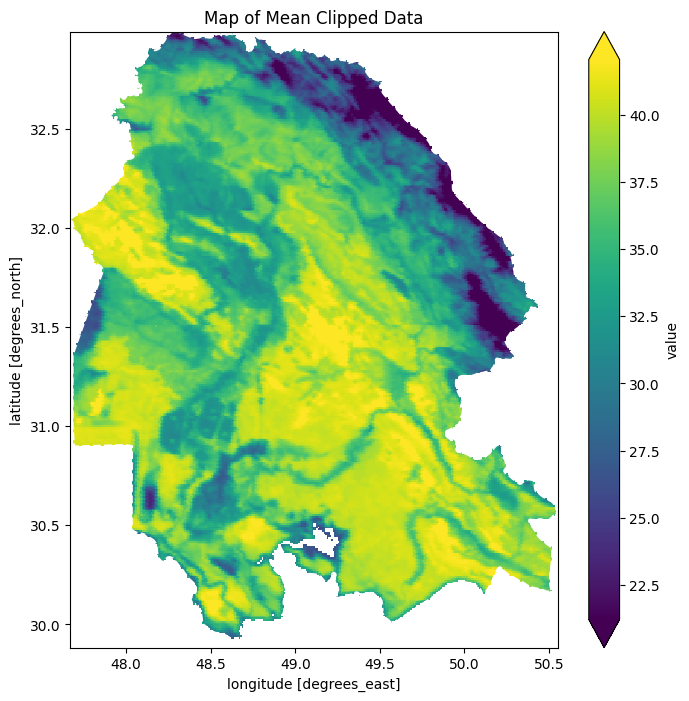

In [ ]:
# =============================================================================
#         PART 1: SETUP, CONFIGURATION, AND DATA LOADING
# =============================================================================
import xarray as xr
import rioxarray
import geopandas as gpd
import numpy as np
import pymannkendall as mk
import pandas as pd
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

# --- USER CONFIGURATION ---
NETCDF_FILE_PATH = r'dataset_LST.nc'
SHAPEFILE_PATH = r'province_Project1.shp'
OUTPUT_CSV_PATH = "Mann_Kendall_LST_Annual_Trends.csv"
DATA_VARIABLE = 'value'
TIME_VARIABLE = 'time'
X_COORD = 'longitude'
Y_COORD = 'latitude'
# --- End of Configuration ---

print("Step 1: Loading and clipping data...")
dataset = xr.open_dataset(NETCDF_FILE_PATH)
gdf = gpd.read_file(SHAPEFILE_PATH)

dataset = dataset.rio.set_spatial_dims(x_dim=X_COORD, y_dim=Y_COORD)
dataset.rio.write_crs("epsg:4326", inplace=True)

clipped_data = dataset.rio.clip(gdf.geometry, gdf.crs, drop=True)
print("Data successfully loaded and clipped.")

# --- Plot the clipped data map for verification ---
print("\nDisplaying map of the clipped data (mean over time)...")
plt.figure(figsize=(8, 8))
clipped_data[DATA_VARIABLE].mean(dim=TIME_VARIABLE).plot(robust=True, cmap='viridis')
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='white', linewidth=1.5, linestyle='--')
plt.title("Map of Mean Clipped Data")
plt.show()

In [7]:
# =============================================================================
#         PART 2: DATA PRE-PROCESSING (USING GROUPBY)
# =============================================================================
print("\nStep 2: Aggregating data to annual averages using groupby...")

# Group the data by year and compute the mean for each pixel.
# This creates a 'year' coordinate instead of a 'time' coordinate.
annual_data = clipped_data[DATA_VARIABLE].groupby(f'{TIME_VARIABLE}.year').mean()

print("Data successfully aggregated to annual values.")
print(f"Annual data dimensions: {annual_data.dims}")


Step 2: Aggregating data to annual averages using groupby...
Data successfully aggregated to annual values.
Annual data dimensions: ('year', 'latitude', 'longitude')



Step 3: Performing Mann-Kendall trend analysis...
Trend analysis configured. Computing results now (progress bar will be displayed)...
[########################################] | 100% Completed | 347.83 s

Trend analysis complete. Formatting and saving results...

Results successfully saved to: Mann_Kendall_LST_Annual_Trends.csv
First 5 rows of the results table:
 stats   latitude  longitude     slope   p_value   z_score
66     32.986137  48.266480  0.034675  0.385310  0.868154
67     32.986137  48.275463  0.034675  0.385310  0.868154
68     32.986137  48.284447  0.028029  0.471939  0.719328
69     32.986137  48.293430  0.022428  0.441931  0.768936
70     32.986137  48.302413  0.025962  0.333358  0.967372

Displaying a map of the trend slope...


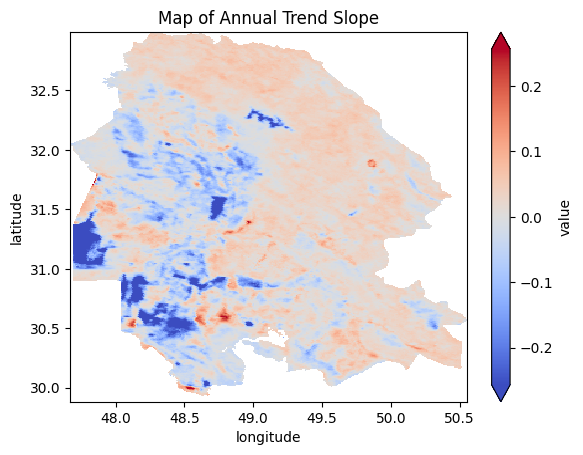


Displaying a map of the P-value...


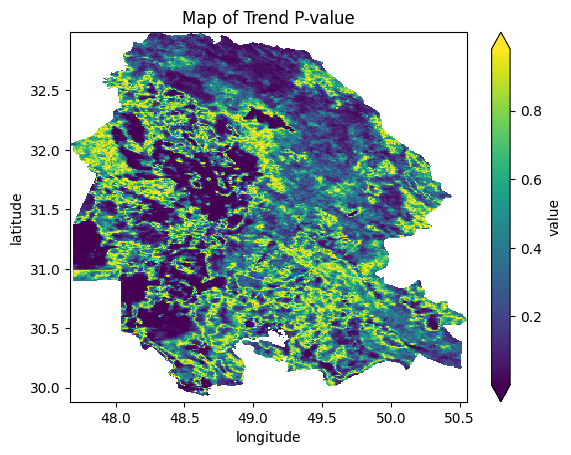


Displaying a map of the Z-score...


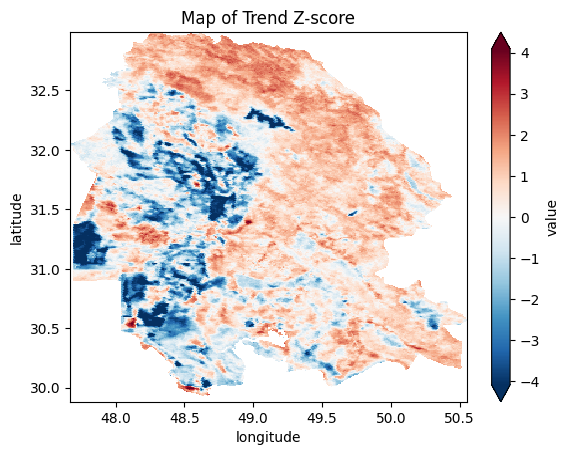

In [12]:
# =============================================================================
#         PART 3: MANN-KENDALL TREND ANALYSIS (VECTORIZED)
# =============================================================================
print("\nStep 3: Performing Mann-Kendall trend analysis...")

# --- NEW: Revised function to handle short/empty time series ---
def mann_kendall_test(x):
    """
    Robust wrapper function to apply the pymannkendall test.
    Checks for a minimum number of data points before running the test.
    """
    # Remove NaN values from the input array
    x_clean = x[~np.isnan(x)]

    # If there are fewer than 2 valid data points, the test is not possible.
    # Return an array of NaNs as a placeholder.
    if len(x_clean) < 2:
        return np.array([np.nan, np.nan, np.nan])

    # If there is enough data, proceed with the test on the cleaned data
    trend_result = mk.original_test(x_clean)
    return np.array([trend_result.slope, trend_result.p, trend_result.z])

# Use Dask for parallel processing
annual_data_chunked = annual_data.chunk({Y_COORD: 100, X_COORD: 100})

# Apply the robust test function across the 'year' dimension
trend_stats = xr.apply_ufunc(
    mann_kendall_test, annual_data_chunked,
    input_core_dims=[['year']],
    output_core_dims=[["stats"]],
    exclude_dims=set(('year',)),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float64],
    dask_gufunc_kwargs={'output_sizes': {'stats': 3}}
)
trend_stats = trend_stats.assign_coords(stats=['slope', 'p_value', 'z_score'])

print("Trend analysis configured. Computing results now (progress bar will be displayed)...")

# Use Dask's ProgressBar to monitor the computation
with ProgressBar():
    computed_trends = trend_stats.compute()

print("\nTrend analysis complete. Formatting and saving results...")
df_results = computed_trends.to_dataframe(name='value').unstack('stats')['value'].reset_index()
# This dropna step will now correctly remove the pixels we flagged with NaN
df_results = df_results.dropna(subset=['slope'])

df_results.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"\nResults successfully saved to: {OUTPUT_CSV_PATH}")
print("First 5 rows of the results table:\n", df_results.head())


# --- PLOT ALL RESULT MAPS ---

# Plot 1: Map of the trend slope
print("\nDisplaying a map of the trend slope...")
# 'coolwarm' is a diverging colormap, good for showing positive/negative trends
computed_trends.sel(stats='slope').plot(cmap='coolwarm', robust=True)
plt.title("Map of Annual Trend Slope")
plt.show()


# Plot 2: Map of the P-value
print("\nDisplaying a map of the P-value...")
# 'viridis' is a sequential colormap. Low p-values (darker colors) indicate higher significance.
computed_trends.sel(stats='p_value').plot(cmap='viridis', robust=True)
plt.title("Map of Trend P-value")
plt.show()


# Plot 3: Map of the Z-score
print("\nDisplaying a map of the Z-score...")
# 'RdBu_r' is another diverging colormap, ideal for z-scores centered on zero.
computed_trends.sel(stats='z_score').plot(cmap='RdBu_r', robust=True)
plt.title("Map of Trend Z-score")
plt.show()